In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from collections import defaultdict
import numpy as np
from IPython import display
from matplotlib import pyplot as plt
from bleu import bleu_from_lines
%matplotlib inline

In [2]:
from torch_utils import pad_sequence
import os

In [3]:
use_cuda = False

In [4]:
PAD_TOKEN = 0
BOS_TOKEN = 1
NAN_TOKEN = 2
EOS_TOKEN = 3
SPECIAL_TOKENS = 4
OCCURING_SPECIAL_TOKENS = 1

In [5]:
class Lang:
    def __init__(self, tokens_file_path):
        self.idx2word = defaultdict(lambda: "<NAN/>")
        self.word2idx = defaultdict(lambda: NAN_TOKEN)
        with open(tokens_file_path) as tokens_file:
            tokens = tokens_file.readlines()
            for word, idx in map(lambda x: x.strip().split(), tokens):
                idx = int(idx) + SPECIAL_TOKENS
                self.idx2word[idx] = word
                self.word2idx[word] = idx
            assert PAD_TOKEN not in self.idx2word
            assert BOS_TOKEN not in self.idx2word
            assert EOS_TOKEN not in self.idx2word
            for word, idx in [('<PAD/>', PAD_TOKEN), ('<S>', BOS_TOKEN),
                              ('</S>', EOS_TOKEN), ('<NAN/>', NAN_TOKEN)]:
                self.idx2word[idx] = word
                self.word2idx[word] = idx
    
    def convert(self, sentence):
        if isinstance(sentence, str):
            sentence = sentence.strip().split()
        return [BOS_TOKEN] + list(map(lambda word: self.word2idx[word], sentence)) + [EOS_TOKEN]
    
    def convert_batch(self, sents):
        
        batch_max_length = 0
        for sent in sents:
            batch_max_length = max(batch_max_length, len(sent))

        
        result = np.zeros(shape=(len(sents), batch_max_length + 1 + 1))
        mask = np.zeros(shape=(len(sents), batch_max_length + 1 + 1))
        
        for sent_id, sent in enumerate(sents):
            sent = sent[:batch_max_length]
            current = self.convert(sent)
            result[sent_id, :len(current)] = current
            mask[sent_id, :len(current)] = 1.0
            
        return result, mask
    
    def input_size(self):
        return len(self.idx2word.keys())
    
    def output_size(self):
        return len(self.idx2word.keys())
    
    def get_word(self, idx):
        return self.idx2word[idx]
    
    def get_eos(self):
        return EOS_TOKEN

In [6]:
def read_file(filename):
    with open(filename) as file:
        return list(map(lambda s: s.strip().split(" "), file.readlines()))

In [7]:
def read_problem(path, n_sents=None):
    modes = ["train",  "dev", "test"]
    datasets = ["src", "tgt"]
    file_template = "{}.{}.txt"
    
    result = {}
    for mode in modes:
        src = read_file(os.path.join(path, file_template.format("src", mode)))
        tgt = read_file(os.path.join(path, file_template.format("tgt", mode)))
        
        assert len(src) == len(tgt)

        if n_sents is not None:
            result[mode] = (src[:n_sents], tgt[:n_sents])
        else:
            result[mode] = (src, tgt)
        
    src_lang = Lang(os.path.join(path, file_template.format("src", "tokens")))
    tgt_lang = Lang(os.path.join(path, file_template.format("tgt", "tokens")))
    return result, src_lang, tgt_lang
        
        

In [8]:
d, src, tgt = read_problem("../preprocessed/he-en/", n_sents=None)

In [9]:
class BatchSampler:
    def __init__(self, dataset, src_lang, tgt_lang, batch_size):
        self.train = np.array(dataset["train"])
        self.dev = np.array(dataset["dev"])
        self.test = np.array(dataset["test"])
        
        np.random.seed(42)
        self.train_indices = np.random.permutation(np.arange(len(self.train[0]), dtype=np.int32))
        
        
        self.src_lang = src_lang
        self.tgt_lang = tgt_lang
        
        self.batch_size = batch_size
    
    def __len__(self):
        return len(self.train) // self.batch_size + 1
        
    def __iter__(self):
        self.position = 0
        return self
    
    def reset(self):
        self.position = 0
        
    
    def get_batch(self, x, y):
        x, x_mask = self.src_lang.convert_batch(x)
        y, y_mask = self.tgt_lang.convert_batch(y)
        
        x = Variable(torch.from_numpy(x.astype(np.int64))).contiguous()
        x_mask = Variable(torch.from_numpy(x_mask.astype(np.float32))).contiguous()
        
        y = Variable(torch.from_numpy(y.astype(np.int64))).contiguous()
        y_mask = Variable(torch.from_numpy(y_mask.astype(np.float32))).contiguous()
        
        return (x, x_mask), (y, y_mask)
    
        
    def __next__(self):
        if self.position >= len(self.train[0]):
            raise StopIteration()

        x = self.train[0][self.train_indices[self.position:self.position + self.batch_size]]
        y = self.train[1][self.train_indices[self.position:self.position + self.batch_size]]

        self.position += self.batch_size
        return self.get_batch(x, y)

        

In [10]:
class HyperParameters:
    def __init__(self):
        self.max_length = 100
        self.enc_hidden_size = 128
        self.enc_emb_size = 128
        self.enc_layers = 1
        self.enc_dropout = 0.1
        self.enc_bidirectional = True
        
        self.dec_hidden_size = 128
        self.dec_emb_size = self.enc_emb_size
        self.dec_layers = 1
        self.dec_dropout = 0.1
        self.dec_bidirectional = True
        
        self.batch_size = 100
        self.learning_rate = 0.001
        self.clip = 0.25
     
    def get_enc_output_size(self):
        return self.enc_hidden_size * (int(self.enc_bidirectional) + 1)
    
    def get_dec_output_size(self):
        return self.dec_hidden_size * (int(self.dec_bidirectional) + 1)
    
    def get_dec_state_size(self):
        return self.dec_hidden_size * (int(self.dec_bidirectional) + 1) * self.dec_layers

In [11]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hp):
        super(EncoderRNN, self).__init__()

        self.embedding = nn.Embedding(num_embeddings=input_size,
                                      embedding_dim=hp.enc_emb_size,
                                      padding_idx=PAD_TOKEN)
        
        self.gru = nn.GRU(input_size=hp.enc_emb_size,
                          hidden_size=hp.enc_hidden_size,
                          batch_first=True,
                          dropout=hp.enc_dropout,
                          num_layers=hp.enc_layers,
                          bidirectional=hp.enc_bidirectional)
        self.num_directions = (int(hp.enc_bidirectional) + 1)
        self.num_layers = hp.enc_layers
        self.hidden_size = hp.enc_hidden_size

    def forward(self, input_batch, hidden=None):
        """
        """

        if (hidden is None):
            hidden = self.init_hidden(input_batch.size(0))
        embedded = self.embedding(input_batch).contiguous()
        outputs, _ = self.gru(embedded, hidden)
        return outputs

    def init_hidden(self, batch_size):
        result = Variable(torch.zeros(
            self.num_layers * self.num_directions, batch_size, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

In [12]:
class Attn(nn.Module):
    def __init__(self, hp):
        super(Attn, self).__init__()
        self.attn = nn.Linear(hp.get_enc_output_size() + hp.get_dec_state_size(), 1)

    def forward(self, hidden, encoder_outputs, mask):
        '''
        :param hidden: 
            previous hidden state of the decoder, in shape (layers * directions, B, HD)
        :param encoder_outputs:
            encoder outputs from Encoder, in shape (B, T, HE)
        :param encoder_output_lengths:
            lengths of encoded sentences, in shape (B,)
        :return
            attention energies in shape (B,T)
        '''
        batch_size = encoder_outputs.size(0)
        max_len = encoder_outputs.size(1)

        hidden = hidden.transpose(0, 1).contiguous() # [B, l * d, HD]
        hidden = hidden.view(batch_size, -1) # [B, HD * layers * directions]
        hidden = hidden.repeat(max_len, 1, 1).transpose(0, 1) # [B, T, HD * layers * directions]
        
        energies = self.attn(torch.cat((hidden, encoder_outputs), -1)).view(batch_size, max_len) # [B, T, 1]

        
        energies = energies * mask
        energies = F.softmax(energies)
        energies = energies * mask
        energies = energies / energies.sum(1).view(-1, 1) # [B, T]
        
        return (energies.view(batch_size, max_len, 1) * encoder_outputs).sum(1) #[B, HE]

In [13]:
class DecoderRNN(nn.Module):
    def __init__(self, input_size, output_size, hp):
        super(DecoderRNN, self).__init__()

        self.embedding = nn.Embedding(input_size, hp.dec_emb_size, padding_idx=PAD_TOKEN)
        self.attn = Attn(hp)
        self.gru = nn.GRU(input_size=hp.dec_emb_size + hp.get_enc_output_size(),
                          hidden_size=hp.dec_hidden_size,
                          num_layers=hp.dec_layers,
                          batch_first=True,
                          dropout=hp.dec_dropout,
                          bidirectional=hp.dec_bidirectional)
        self.out = nn.Linear(hp.get_dec_output_size(), output_size)

        self.num_layers = hp.dec_layers
        self.num_directions = int(hp.dec_bidirectional) + 1
        self.output_size = output_size
        self.hidden_size = hp.dec_hidden_size


    def forward(self, input, encoder_outputs, mask, hidden=None):
        """
            input: [B,]
            encoder_outputs: [B, T, HE]
            hidden: [B, layers * directions, HD]
        """
        batch_size = input.size(0)
        if hidden is None:
            hidden = self.init_hidden(batch_size)
        embedded = self.embedding(input)
        context = self.attn(hidden, encoder_outputs, mask).view(batch_size, -1)
        rnn_input = torch.cat((embedded, context), -1).view(batch_size, 1, -1)
        
        output, next_hidden = self.gru(rnn_input, hidden)
        output = self.out(output).view(batch_size, self.output_size)
        output = F.log_softmax(output, -1)
        
        return output, next_hidden

    def init_hidden(self, batch_size):
        result = Variable(torch.zeros(
            self.num_layers * self.num_directions, batch_size, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

In [14]:
class Seq2Seq(nn.Module):
    def __init__(self, source_lang, target_lang, hp):
        super(Seq2Seq, self).__init__()
        self.source_lang = source_lang
        self.target_lang = target_lang
        self.encoder = EncoderRNN(source_lang.input_size(), hp)
        self.decoder = DecoderRNN(target_lang.input_size(), target_lang.input_size(), hp)
        self.max_length = hp.max_length
        self.criterion = nn.NLLLoss(reduce=False, size_average=False)

    def translate(self, input_batch, mask):
        batch_size = input_batch.size()[0]
        encoder_outputs = self.encoder(input_batch)

        
        hidden = None
        
        logits = []
        word_indices = []
        
        dec_input = Variable(torch.LongTensor([BOS_TOKEN] * batch_size))
        
        if use_cuda:
            dec_input = dec_input.cuda()
        
        MAX_LENGTH = 100
        translations = [[BOS_TOKEN] for _ in range(batch_size)]
        converged = np.zeros(shape=(batch_size, ))
        for i in range(MAX_LENGTH):     
            output, hidden = self.decoder(dec_input, encoder_outputs, mask=mask, hidden=hidden)
            _, output_idx = torch.max(output, -1)
                
            for j in range(batch_size):
                if translations[j][-1] != self.target_lang.get_eos():
                    translations[j].append(output_idx[j].data[0])
                else:
                    converged[j] = True
            dec_input = Variable(torch.LongTensor([tr[-1] for tr in translations]))
            
            if use_cuda:
                dec_input = dec_input.cuda()
            
            
            if np.all(converged):
                break
        return [' '.join(map(self.target_lang.get_word, elem)) for elem in translations]
    
    def forward(self, input_batch, mask, output_batch, out_mask):
        encoder_outputs = self.encoder(input_batch)
        
        hidden = None
        
        logits = []
        loss = 0
        outputs = []
        for i in range(out_mask.size()[1] - 1):
           
            output, hidden = self.decoder(output_batch[:, i], encoder_outputs, mask=mask, hidden=hidden)
            loss += (self.criterion(output, output_batch[:, i + 1]) * out_mask[:, i + 1]).sum()
        
        loss /= out_mask.sum()
        return loss
        

In [15]:
import tqdm
import gc
def trainS2S(s2s, batch_sampler, hp):
    s2s.train()
    losses = []
    optimizer = torch.optim.Adam(s2s.parameters(), lr=hp.learning_rate)
    
    for epoch_id in range(hp.n_epochs):
        for batch_id, ((input, input_mask), (output, output_mask)) in tqdm.tqdm(enumerate(batch_sampler)):
            if use_cuda:
                input = input.cuda()
                input_mask = input_mask.cuda()
                output = output.cuda()
                output_mask = output_mask.cuda()


            loss = s2s(input, input_mask, output, output_mask)
            optimizer.zero_grad()
            
            loss.backward()
            torch.nn.utils.clip_grad_norm(s2s.parameters(), hp.clip)
            optimizer.step()
            if use_cuda:
                losses.append(loss.cpu().data[0])
            else:
                 losses.append(loss.data[0])
            
            if (batch_id * batch_sampler.batch_size) % 1000 == 0:
                display.clear_output(wait=True)
                print("Last 10 loses mean", np.mean(losses[-10:]))
                plt.plot(losses)
                plt.show()
        
        torch.save(s2s.state_dict(), "last_state.ckpt")
        gc.collect()
        if use_cuda:
            torch.cuda.empty_cache()
        
        
    return losses

In [16]:
dummy_dataset = {
    "train": ( ["'a 'a d y r", "'a 'a h b ckh"], ["a a d i r", "e a h a v k h a"]),
    "test":None,
    "dev":None
}

In [94]:
class Trainer:
    def __init__(self, s2s, batch_sampler, hp):
        self.hp = hp
        self.s2s = s2s
        self.batch_sampler = batch_sampler
        self.losses = []
        self.bleu = []
    
    def reset(self):
        pass

    @staticmethod
    def for_translation(x, x_mask):
        if not use_cuda:
            x = Variable(torch.from_numpy(x.astype(np.int64))).contiguous()
            x_mask = Variable(torch.from_numpy(x_mask.astype(np.float32))).contiguous()
        else:
            x = Variable(torch.from_numpy(x.astype(np.int64))).contiguous().cuda()
            x_mask = Variable(torch.from_numpy(x_mask.astype(np.float32))).contiguous().cuda()

        return x, x_mask
    
    @staticmethod
    def run_translation(model, test_data, batch_size):
        result = []
        for pos in range(0, test_data.shape[0], batch_size):
            batch, mask = Trainer.for_translation(*src.convert_batch(test_data[pos:pos + batch_size]))
            translated = model.translate(batch, mask)
            result.extend(translated)


        real_result = []
        for sent in result:
            sent = sent.split(" ")[1:-1]
            real_result.append(" ".join(sent))
        return real_result
    
    def validate(self):
        model = self.s2s
        test_data = self.batch_sampler.dev[0]
        translation = self.run_translation(model, test_data, hp.batch_size)
        real_translation = [' '.join(x) for x in self.batch_sampler.dev[1]]
        return bleu_from_lines(real_translation, translation)
    
    def train(self):
        s2s = self.s2s
        batch_sampler = self.batch_sampler
        hp = self.hp
        losses = self.losses
        bleu = self.bleu
        
        s2s.train()
        optimizer = torch.optim.Adam(s2s.parameters(), lr=hp.learning_rate)
        for epoch_id in range(hp.n_epochs):
            print("Len: ", len(batch_sampler))
            for batch_id, ((input, input_mask), (output, output_mask)) in \
                tqdm.tqdm(enumerate(batch_sampler), total=len(batch_sampler)):
                if use_cuda:
                    input = input.cuda()
                    input_mask = input_mask.cuda()
                    output = output.cuda()
                    output_mask = output_mask.cuda()


                loss = s2s(input, input_mask, output, output_mask)
                optimizer.zero_grad()

                loss.backward()
                torch.nn.utils.clip_grad_norm(s2s.parameters(), hp.clip)
                optimizer.step()
                if use_cuda:
                    losses.append(loss.cpu().data[0])
                else:
                     losses.append(loss.data[0])

                if (batch_id * batch_sampler.batch_size) % 1000 == 0:
                    display.clear_output(wait=True)
                    print("Last 10 loses mean", np.mean(losses[-10:]))
                    plt.plot(losses)
                    plt.show()
            s2s.eval()
            bleu.append(self.validate())
            print("Bleu: ", bleu[-1])
            s2s.train()

            torch.save(s2s.state_dict(), "last_state.ckpt")
            gc.collect()
            if use_cuda:
                torch.cuda.empty_cache()
        

In [98]:
hp.batch_size = 100
batch_sampler = BatchSampler(d, src, tgt, hp.batch_size)

In [99]:
hp.n_epochs = 5
trainer = Trainer(s2s, batch_sampler, hp)

Last 10 loses mean 0.506020635366


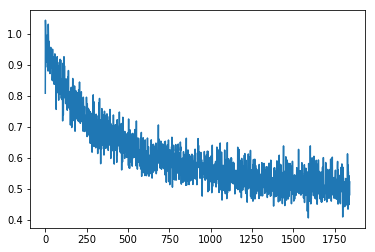

18it [00:04,  3.60it/s]


KeyboardInterrupt: 

In [100]:
trainer.train()

In [103]:
trainer.bleu

[0.5329257566948042]

In [97]:
trainer.validate()

/home/thefacetakt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0.28348408067920816